## Created by yunsuxiaozi 2024/3/19

### MNIST数据集可以说是计算机视觉领域的"hello world",在本文当中,我将带大家搭建一个简单的CNN模型,来对这个数据集进行分类.(这里只是实现代码逻辑,如果想达到更好的效果可以尝试网络模型的加深和迭代次数的增加)

#### 首先是导入一些基础的库,这些库有的是读取csv文件的,有的是处理numpy或者torch.tensor数据的.

In [1]:
import pandas as pd#导入csv文件的库
import numpy as np#进行矩阵运算的库
import matplotlib.pyplot as plt#一个强大的绘图库

import torch #一个深度学习的库Pytorch
import torch.nn as nn#neural network,神经网络
import torch.nn.functional as F#神经网络函数库
import torch.optim as optim#一个实现了各种优化算法的库
import warnings#避免一些可以忽略的报错
warnings.filterwarnings('ignore')#filterwarnings()方法是用于设置警告过滤器的方法，它可以控制警告信息的输出方式和级别。

#### 这里来设置一些参数

- seed:随机种子是为了保证每次程序运行的结果一致

- batch_size:batch_size是我们需要将所有的数据分批次进行训练.图像数据大小是(28,28)的矩阵,数据量为42000,就是(42000,28,28)的矩阵,如果遇到更大型的图像分类任务,将数据一次性传入模型,可能会出现内存不足的问题.

- num_epochs:模型的训练次数.

- num_classes:图像分类任务的类别数量.

- num_folds:这是K折交叉验证.交叉验证一般是在表格数据中使用,但是在这种小型图像数据同时计算资源足够的前提下,可以通过K折交叉验证达到更好的效果.

- train_path:训练数据的文件路径.

- test_path:测试数据的文件路径.

In [2]:
class Config:
    seed=2024#随机种子
    batch_size=128#每次传入的图像数据
    num_epochs=10#模型训练10个epoch即可.
    num_classes=10#图像的类别数.
    num_folds=5#5折交叉验证
    train_path="/kaggle/input/digit-recognizer/train.csv"
    test_path="/kaggle/input/digit-recognizer/test.csv"

#### 随机种子固定,保证程序可以复现.

In [3]:
#设置随机种子
import random
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True#将cuda加速的随机数生成器设为确定性模式
    torch.backends.cudnn.benchmark = False#关闭CuDNN框架的自动寻找最优卷积算法的功能，以避免不同的算法对结果产生影响
    torch.manual_seed(seed)#pytorch的随机种子
    np.random.seed(seed)#numpy的随机种子
    random.seed(seed)#python内置的随机种子
seed_everything(Config.seed)

我们这里先准备好训练数据和测试数据

In [4]:
train_df=pd.read_csv(Config.train_path)
X=train_df.drop(['label'],axis=1).values.reshape(-1,1,28,28)
y=train_df['label'].values
print(f"X.shape:{X.shape},y.shape:{y.shape}")
test_df=pd.read_csv(Config.test_path)
test_X=test_df.values.reshape(-1,1,28,28)
print(f"test_X.shape:{test_X.shape}")

X.shape:(42000, 1, 28, 28),y.shape:(42000,)
test_X.shape:(28000, 1, 28, 28)


#### 我们接下来搭建模型,这里是两层卷积层,一个全连接层和一个输出层.

- init:初始化函数,一般用来写神经网络的各种模块.

- forward:前向传播函数.图像数据在神经网络中做了什么都在这个函数实现.

In [5]:
class MNISTCNN(nn.Module):
    def __init__(self,num_classes=Config.num_classes):
        super(MNISTCNN,self).__init__()
        self.num_classes=num_classes
        self.conv=nn.Sequential(
                  #1*28*28->6*28*28
                  nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1,padding=1),
                  nn.BatchNorm2d(6),
                  #6*28*28->6*14*14
                  nn.MaxPool2d(kernel_size=2,stride=2),
                  nn.GELU(),
                  #6*14*14->64*14*14
                  nn.Conv2d(in_channels=6,out_channels=64,kernel_size=3,stride=1,padding=1),
                  nn.BatchNorm2d(64),
                  #64*14*14->64*7*7
                  nn.MaxPool2d(kernel_size=2,stride=2),
                  nn.GELU(),
        )
        self.head=nn.Sequential(
                nn.Linear(64*7*7,128),
                nn.BatchNorm1d(128),
                nn.GELU(),
                nn.Linear(128,self.num_classes),
        )
        
    def forward(self,x):
        x=self.conv(x).reshape(x.shape[0],-1)
        x=self.head(x)
        return F.softmax(x,dim=-1)

#### 接下来就是模型的训练了,这里用5折交叉验证训练5个神经网络.损失函数是交叉熵损失函数,评估指标是准确率.训练好一个模型可以作图看看训练数据和测试数据的损失和准确率情况,并作图.保存好训练好的模型.

device:cpu
fold:0------------------------
epoch:0
train_loss:0.4326461851596832,train_accuracy:0.8719460227272727
valid_loss:0.15215693414211273,valid_accuracy:0.9455501425855514
epoch:1
train_loss:0.1485726237297058,train_accuracy:0.9522964015151515
valid_loss:0.12263674288988113,valid_accuracy:0.9609672053231939
epoch:2
train_loss:0.0876186341047287,train_accuracy:0.9715909090909091
valid_loss:0.08930324763059616,valid_accuracy:0.9685123574144486
epoch:3
train_loss:0.05713804438710213,train_accuracy:0.9810606060606061
valid_loss:0.07201742380857468,valid_accuracy:0.9713046577946768
epoch:4
train_loss:0.04138988256454468,train_accuracy:0.9866950757575758
valid_loss:0.08055771887302399,valid_accuracy:0.964115969581749
epoch:5
train_loss:0.03189753741025925,train_accuracy:0.9898910984848486
valid_loss:0.07419072836637497,valid_accuracy:0.9670865019011406
epoch:6
train_loss:0.020160380750894547,train_accuracy:0.9942945075757574
valid_loss:0.05728243291378021,valid_accuracy:0.976918963878

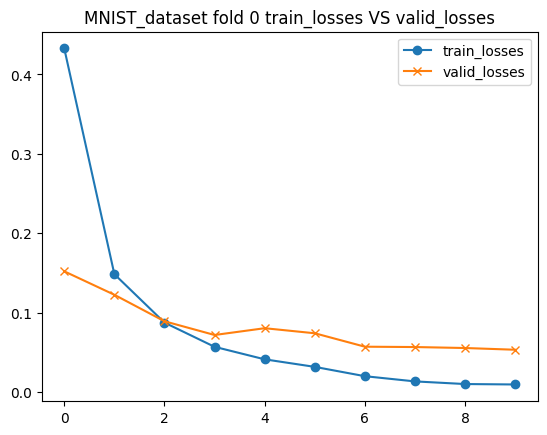

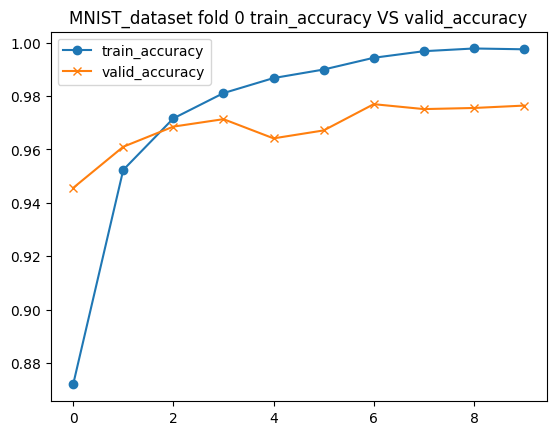

fold:1------------------------
epoch:0
train_loss:0.4571642577648163,train_accuracy:0.8597064393939394
valid_loss:0.17356707155704498,valid_accuracy:0.9367276615969582
epoch:1
train_loss:0.1518057882785797,train_accuracy:0.9484138257575757
valid_loss:0.13701027631759644,valid_accuracy:0.9593334125475285
epoch:2
train_loss:0.0822143480181694,train_accuracy:0.9746448863636363
valid_loss:0.09763979911804199,valid_accuracy:0.9660171102661597
epoch:3
train_loss:0.05260542780160904,train_accuracy:0.9845170454545455
valid_loss:0.07553643733263016,valid_accuracy:0.9688985266159695
epoch:4
train_loss:0.0349472239613533,train_accuracy:0.9896070075757577
valid_loss:0.07810989022254944,valid_accuracy:0.9649180133079848
epoch:5
train_loss:0.02640759013593197,train_accuracy:0.9933948863636365
valid_loss:0.07103096693754196,valid_accuracy:0.9683341254752852
epoch:6
train_loss:0.01936466246843338,train_accuracy:0.9946969696969697
valid_loss:0.07026758790016174,valid_accuracy:0.9693738117870723
epoch:7

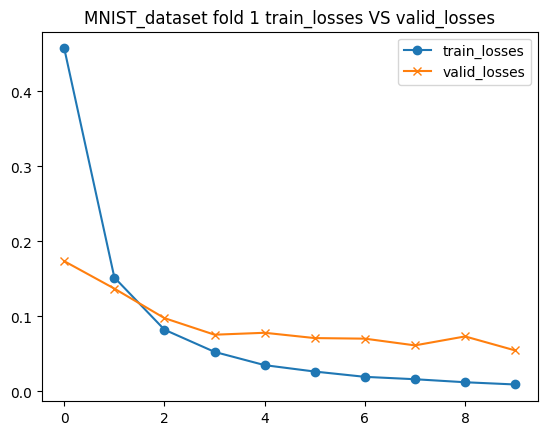

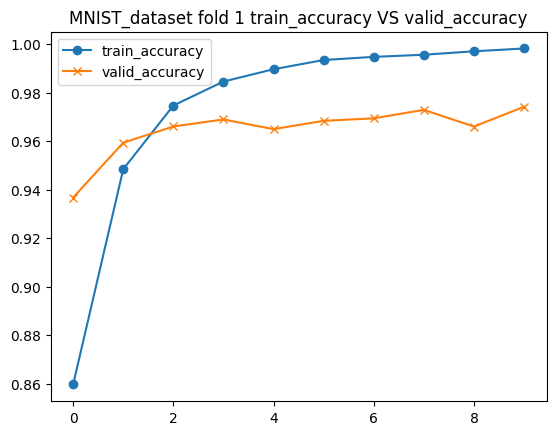

fold:2------------------------
epoch:0
train_loss:0.4661214351654053,train_accuracy:0.8665719696969697
valid_loss:0.1761670708656311,valid_accuracy:0.9370247148288974
epoch:1
train_loss:0.15437127649784088,train_accuracy:0.9500710227272727
valid_loss:0.13091404736042023,valid_accuracy:0.9617098384030418
epoch:2
train_loss:0.08467965573072433,train_accuracy:0.9734375000000001
valid_loss:0.09673801064491272,valid_accuracy:0.9684826520912547
epoch:3
train_loss:0.05386889725923538,train_accuracy:0.9847774621212121
valid_loss:0.0709172785282135,valid_accuracy:0.9729681558935361
epoch:4
train_loss:0.03389133885502815,train_accuracy:0.990909090909091
valid_loss:0.07195998728275299,valid_accuracy:0.9722255228136882
epoch:5
train_loss:0.023423967882990837,train_accuracy:0.9941051136363637
valid_loss:0.06234392523765564,valid_accuracy:0.9732949144486692
epoch:6
train_loss:0.017333008348941803,train_accuracy:0.9964251893939393
valid_loss:0.07515235990285873,valid_accuracy:0.9663438688212928
epoch

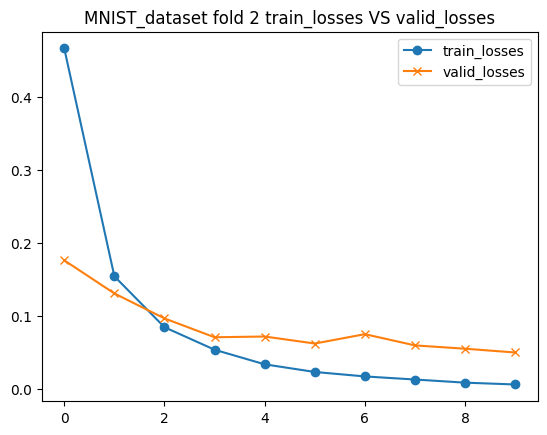

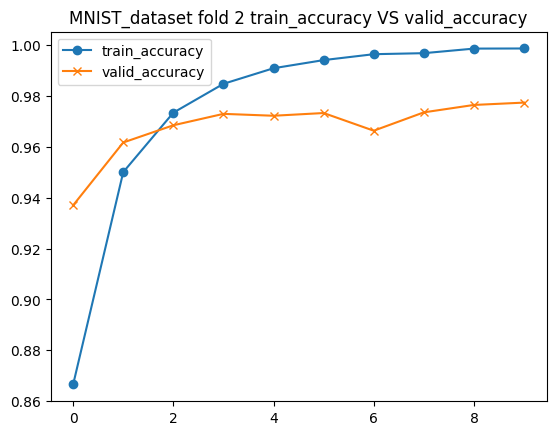

fold:3------------------------
epoch:0
train_loss:0.45811623334884644,train_accuracy:0.8669034090909091
valid_loss:0.1676974892616272,valid_accuracy:0.94106463878327
epoch:1
train_loss:0.15356700122356415,train_accuracy:0.9510179924242425
valid_loss:0.12676094472408295,valid_accuracy:0.9603433935361216
epoch:2
train_loss:0.08796390146017075,train_accuracy:0.9714488636363635
valid_loss:0.09671449661254883,valid_accuracy:0.9675914923954373
epoch:3
train_loss:0.05942016839981079,train_accuracy:0.9796164772727272
valid_loss:0.08532676845788956,valid_accuracy:0.9653635931558935
epoch:4
train_loss:0.041586264967918396,train_accuracy:0.9871922348484847
valid_loss:0.07741677761077881,valid_accuracy:0.9683341254752852
epoch:5
train_loss:0.027054980397224426,train_accuracy:0.991998106060606
valid_loss:0.06465048342943192,valid_accuracy:0.9737701996197718
epoch:6
train_loss:0.016787422820925713,train_accuracy:0.9953598484848484
valid_loss:0.05939924716949463,valid_accuracy:0.9748990019011406
epoc

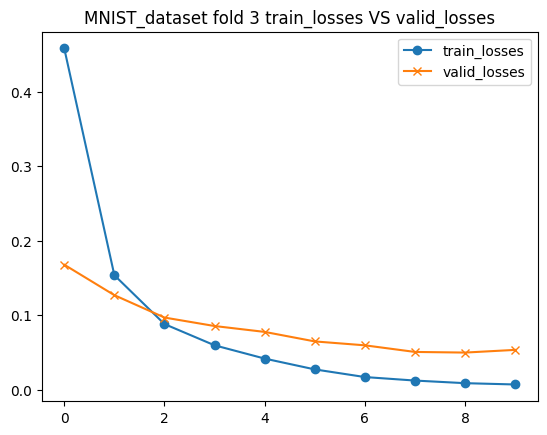

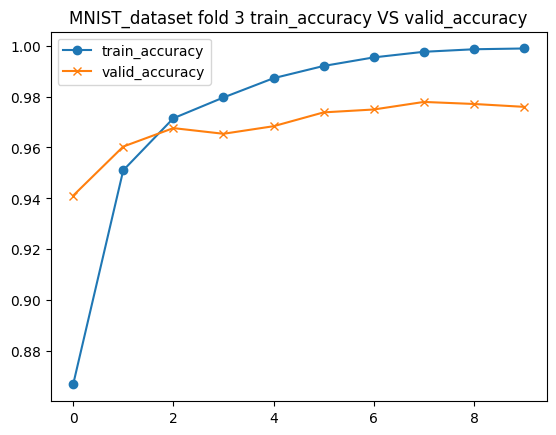

fold:4------------------------
epoch:0
train_loss:0.46389302611351013,train_accuracy:0.8645359848484849
valid_loss:0.1717570573091507,valid_accuracy:0.940678469581749
epoch:1
train_loss:0.1514839231967926,train_accuracy:0.951657196969697
valid_loss:0.1289154291152954,valid_accuracy:0.9615910171102662
epoch:2
train_loss:0.08355448395013809,train_accuracy:0.9745265151515151
valid_loss:0.08738701045513153,valid_accuracy:0.9686311787072244
epoch:3
train_loss:0.052679192274808884,train_accuracy:0.9832859848484847
valid_loss:0.07827634364366531,valid_accuracy:0.9679776615969582
epoch:4
train_loss:0.037196893244981766,train_accuracy:0.989938446969697
valid_loss:0.07510387152433395,valid_accuracy:0.9670270912547528
epoch:5
train_loss:0.023673830553889275,train_accuracy:0.9949100378787878
valid_loss:0.05474404618144035,valid_accuracy:0.9766219106463878
epoch:6
train_loss:0.01601831242442131,train_accuracy:0.9968513257575757
valid_loss:0.05941544100642204,valid_accuracy:0.9755525190114068
epoch:

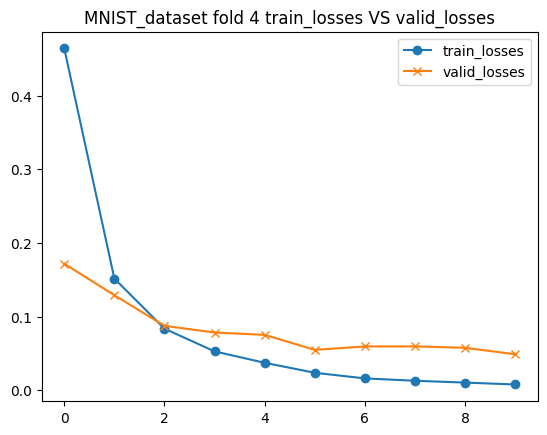

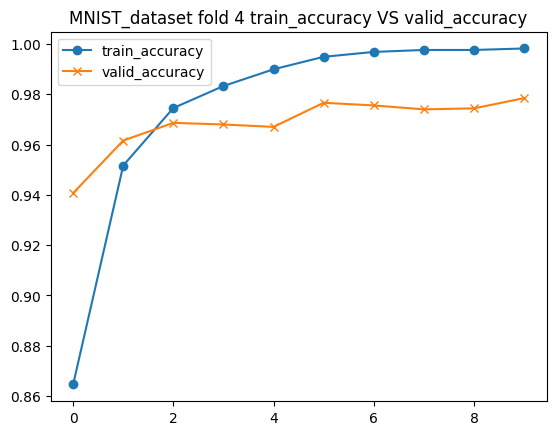

In [6]:
def cross_entropy_loss(y_pro,y_target,eps=1e-15):
    y_target=torch.eye(int(y_pro.shape[-1]))[y_target]
    y_pro=torch.clip(y_pro,eps,1-eps)
    y_target=torch.clip(y_target,eps,1-eps)
    return -torch.mean(torch.sum(y_target*((1-y_pro))*torch.log(y_pro),dim=1),dim=0)
def accuracy(y_true,y_pred):
    return np.mean(y_true==y_pred)

device='cuda' if torch.cuda.is_available() else"cpu"
print(f"device:{device}")

total_idx=np.arange(len(X))
np.random.shuffle(total_idx)
for fold in range(Config.num_folds):
    print(f"fold:{fold}------------------------")
    #交叉验证每次训练数据和验证数据的划分
    train_idx=total_idx[fold*len(X)//Config.num_folds:(fold+1)*len(X)//Config.num_folds]
    valid_idx=[idx for idx in total_idx if idx not in train_idx]
    train_X,train_y=X[train_idx],y[train_idx]
    valid_X,valid_y=X[valid_idx],y[valid_idx]
    #模型设置
    model=MNISTCNN().to(device)
    #优化器设置
    optimizer=optim.Adam(model.parameters(),lr=0.00025,betas=(0.5,0.999))
    train_losses=[]
    valid_losses=[]
    train_accuracys=[]
    valid_accuracys=[]
    for epoch in range(Config.num_epochs):
        print(f"epoch:{epoch}")
        #模型设置为训练状态
        model.train()
        #将梯度清空
        optimizer.zero_grad()
        train_loss=[]
        train_accuracy=[]
        for idx in range(0,len(train_X),Config.batch_size):
            train_X1=torch.Tensor(train_X[idx:idx+Config.batch_size])
            train_y1=torch.Tensor(train_y[idx:idx+Config.batch_size]).long()
            train_pro=model(train_X1)
            loss=cross_entropy_loss(train_pro,train_y1)
            train_pred=torch.argmax(train_pro,axis=1).detach().numpy()
            train_y1=train_y1.detach().numpy()
            #反向传播
            loss.backward()
            #优化器进行优化(梯度下降,降低误差)
            optimizer.step()
            train_loss.append(loss.detach().numpy())
            train_accuracy.append(accuracy(train_y1,train_pred))
        train_loss=np.mean(np.array(train_loss))
        train_accuracy=np.mean(np.array(train_accuracy))
        print(f"train_loss:{train_loss},train_accuracy:{train_accuracy}")
        #模型设置为评估模式
        model.eval()
        with torch.no_grad():
            valid_loss=[]
            valid_accuracy=[]
            for idx in range(0,len(valid_X),Config.batch_size):
                valid_X1=torch.Tensor(valid_X[idx:idx+Config.batch_size])
                valid_y1=torch.Tensor(valid_y[idx:idx+Config.batch_size]).long()
                valid_pro=model(valid_X1)
                loss=cross_entropy_loss(valid_pro,valid_y1)
                valid_pred=torch.argmax(valid_pro,axis=1).detach().numpy()
                valid_y1=valid_y1.detach().numpy()
                valid_loss.append(loss.detach().numpy())
                valid_accuracy.append(accuracy(valid_y1,valid_pred))
        valid_loss=np.mean(np.array(valid_loss))
        valid_accuracy=np.mean(np.array(valid_accuracy))
        print(f"valid_loss:{valid_loss},valid_accuracy:{valid_accuracy}")
        train_losses.append(train_loss)
        train_accuracys.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracys.append(valid_accuracy)
    torch.save(model,f"fold{fold}.pth")
    epochs=np.arange(Config.num_epochs)
    plt.title(f"MNIST_dataset fold {fold} train_losses VS valid_losses")
    plt.plot(epochs,train_losses,marker="o",label="train_losses")
    plt.plot(epochs,valid_losses,marker="x",label="valid_losses")
    plt.legend()
    plt.show()
    plt.title(f"MNIST_dataset fold {fold} train_accuracy VS valid_accuracy")
    plt.plot(epochs,train_accuracys,marker="o",label="train_accuracy")
    plt.plot(epochs,valid_accuracys,marker="x",label="valid_accuracy")
    plt.legend()
    plt.show()

#### 这里使用训练好的模型对测试数据进行预测.

In [7]:
print("eval")
test_pros=np.zeros((Config.num_folds,len(test_X),Config.num_classes))
for fold in range(Config.num_folds):
    print(f"fold:{fold}")
    model=torch.load(f"fold{fold}.pth")
    model.eval()
    with torch.no_grad():
        for idx in range(0,len(test_X),Config.batch_size):
            test_X1=torch.Tensor(test_X[idx:idx+Config.batch_size])
            test_pro=model(test_X1).detach().numpy()
            test_pros[fold,idx:idx+len(test_X1)]=test_pro
test_pros=test_pros.mean(axis=0)
test_preds=np.argmax(test_pros,axis=1)
test_preds

eval
fold:0
fold:1
fold:2
fold:3
fold:4


array([2, 0, 9, ..., 3, 9, 2])

#### 最后,可以将预测结果赋值给submission,然后进行提交.

In [8]:
submission=pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
submission['Label']=test_preds
submission.to_csv("submission.csv",index=None)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
